# Ocotillo Valley

In [1]:
import sys
import numpy as np
import numpy.ma as ma
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import flopy
import flopy.utils.binaryfile as bf
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter

## Pre-process GIS files to convert them into MODFLOW-friendly csv files ##

In [162]:
run = False      #to run each section, set to True
if run:         #if run is True, run the section
    
    #Clip text file extent and convert to csv:
    files = ['dem','valley','recharge','ag','riparian','stream','stage','wells']
    fig,ax = plt.subplots(1,len(files), figsize=(30,10))
    for i,f in enumerate(files):
        a = np.asarray(pd.read_csv(f+'1000.txt', header=None, skiprows=6, delimiter=' ', na_values=-9999))
        print(np.shape(a))
        a = a[65:315,110:255]
        #print(np.shape(a))
        if f == 'recharge':
            a[a>0] = 1
        if f == 'dem':
            a = a + 1500
        ax[i].imshow(a)
        ax[i].set_xlabel(f)
        np.savetxt(f+'.csv', a, delimiter=',')

#IMPORTANT: Manually smooth out bump first!        
#Make a smoother version of topography to avoid convergence errors
run = False
if run:
    n = 3
    fig,ax = plt.subplots(1,n+1,figsize=(30,10))
    for i in range(n):
        print(i)
        topo = np.genfromtxt('dem_smooth.csv', delimiter=',')   #load the model topography from a csv file. It will then be used to define the model grid.
        ax[i].imshow(topo)
        ax[i].set_xlabel('smoothing='+str(i))
        w = 3
        nrow = np.shape(topo)[0]
        ncol = np.shape(topo)[1]
        smooth = np.full((nrow,ncol),500.)
        for row in range(nrow):
            for col in range(ncol):
                z = topo[row,col]
                try:
                    zavg = np.mean(topo[row-w:row+w,col-w,row+w])
                except:
                    try:
                        zavg = np.mean(topo[row-w:row,col-w,col])
                    except:
                        try:
                            zavg = np.mean(topo[row:row+w,col:col+w])
                        except:
                            print('averaging error')
                smooth[row,col] = zavg
        np.savetxt('dem_smooth.csv', smooth, delimiter=',')   #overwrite with new smoothed dem
    ax[i+1].imshow(smooth)
    ax[i+1].set_xlabel('smoothing='+str(i))
        
#Make a curved bottom elevation array:
run = False
if run:
    topo = np.genfromtxt('dem_smooth.csv', delimiter=',')
    zbot = topo - 0.02*(np.nanmax(topo)-topo)**1.4 - 250    #make a curved bottom surface
    np.savetxt('bedrock.csv', zbot, delimiter=',')             #save the new bottom elev
    #IMPORTANT: must go in manually and smooth out the weird hump in southern part of valley before proceeding to next step!!!

#Make the bottom elevation smooth:
run = False
if run:
    zbot = np.genfromtxt('bedrock.csv', delimiter=',') + 45      #load the manually corrected bedrock surface
    np.savetxt('zbot.csv', zbot, delimiter=',')             #save with new filename

    n = 2
    fig,ax = plt.subplots(1,n+1,figsize=(20,10))

    for i in range(n):
        print(i)
        zbot = np.genfromtxt('zbot.csv', delimiter=',')   #load the model topography from a csv file. It will then be used to define the model grid.
        ax[i].imshow(zbot)
        ax[i].set_xlabel('smoothing='+str(i))
        w = 6
        nrow = np.shape(zbot)[0]
        ncol = np.shape(zbot)[1]
        smooth = np.full((nrow,ncol),500.)
        for row in range(nrow):
            for col in range(ncol):
                z = zbot[row,col]
                try:
                    zavg = np.mean(zbot[row-w:row+w,col-w,row+w])
                except:
                    try:
                        zavg = np.mean(zbot[row-w:row,col-w,col])
                    except:
                        try:
                            zavg = np.mean(zbot[row:row+w,col:col+w])
                        except:
                            print('averaging error')
                smooth[row,col] = zavg
        np.savetxt('zbot.csv', smooth, delimiter=',')   #overwrite with new smoothed array
    ax[i+1].imshow(smooth)
    ax[i+1].set_xlabel('smoothing='+str(i))

#Make stream valley:
run = False
if run:
    topo = np.genfromtxt('dem_smooth.csv', delimiter=',')
    stream = np.genfromtxt('reaches.csv', delimiter=',')
    stage = np.genfromtxt('stage_manual.csv', delimiter=',')
    reaches = np.arange(len(stage))
    f1,ax = plt.subplots(1,2,figsize=(30,15))
    ax[0].imshow(topo)
    ax[0].imshow(stream, cmap='bone' )
    f2,ax2 = plt.subplots(1,1,figsize=(15,5))
    ax2.plot(reaches,stage, c='skyblue' )
    f3,ax3 = plt.subplots(1,1,figsize=(15,5))
    
             
    w=12
    zorig = []
    for reach in reaches:
        row = np.where(stream==reach+1)[0][0]     #find the row the reach is in
        col = np.where(stream==reach+1)[1][0]     #find the column the reach is in 
        zorig.append(topo[row,col])
        zstrip = topo[row,col-w:col+w]
        zmin = np.min(zstrip)
        zleft = zstrip[0]
        zright = zstrip[-1]
        newleft = np.linspace(zleft,zmin,w-5)
        newright = np.linspace(zmin,zright,w-5)
        newmiddle = np.full(10,zmin)
        newstrip = np.concatenate((newleft,newmiddle,newright))
        if row in [50,70,90,110,130]:
            ax3.plot(np.arange(np.shape(topo)[1]), topo[row,:])
        topo[row,col-w:col+w] = newstrip
        if row in [50,70,90,110,130]:
            ax3.plot(np.arange(np.shape(topo)[1]), topo[row,:])
    np.savetxt('dem_river.csv', topo, delimiter=',')   #overwrite with new smoothed dem
        
    ax[1].imshow(topo)
    ax[1].imshow(stream, cmap='bone' )
    
    newz = []
    for reach in reaches:
        row = np.where(stream==reach+1)[0][0]     #find the row the reach is in
        col = np.where(stream==reach+1)[1][0]     #find the column the reach is in 
        newz.append(topo[row,col])
    ax2.plot(reaches,zorig, c='purple')
    ax2.plot(reaches,newz, c='red')
    
#Smooth again after adjusting topo:
run = False
if run:
    n = 1
    f3,ax3 = plt.subplots(1,n+1,figsize=(30,10))
    for i in range(n):
        print(i)
        topo = np.genfromtxt('dem_river.csv', delimiter=',')   #load the model topography from a csv file. It will then be used to define the model grid.
        ax3[i].imshow(topo)
        ax3[i].set_xlabel('smoothing='+str(i))
        w = 3
        nrow = np.shape(topo)[0]
        ncol = np.shape(topo)[1]
        smooth = np.full((nrow,ncol),500.)
        for row in range(nrow):
            for col in range(ncol):
                z = topo[row,col]
                try:
                    zavg = np.mean(topo[row-w:row+w,col-w,row+w])
                except:
                    try:
                        zavg = np.mean(topo[row-w:row,col-w,col])
                    except:
                        try:
                            zavg = np.mean(topo[row:row+w,col:col+w])
                        except:
                            print('averaging error')
                smooth[row,col] = zavg
        np.savetxt('dem_river_smooth.csv', smooth, delimiter=',')   #overwrite with new smoothed dem
        ax3[i+1].imshow(smooth)
        ax3[i+1].set_xlabel('smoothing='+str(i))
    
    topo = np.genfromtxt('dem_river_smooth.csv', delimiter=',')
    zsmooth = []
    for reach in reaches:
        row = np.where(stream==reach+1)[0][0]     #find the row the reach is in
        col = np.where(stream==reach+1)[1][0]     #find the column the reach is in 
        zsmooth.append(topo[row,col])
    f = plt.figure()
    plt.plot(reaches,zsmooth, c='orange')

## Model set up ##

In [19]:
##Name:
modelname = "ocotillo"

##Units:
itmuni = 5                        #time unit: 1:sec, 2:min, 3:hr, 4:day, 5:year
lenuni = 2                        #length unit: 1:ft, 2:meters

##Zones: load from csv files
topo = np.genfromtxt('dem_river.csv', delimiter=',')   #load the model topography from a csv file. It will then be used to define the model grid.
ztop = topo.copy()                                     #make a copy of the topo array to use without messing up original
zbot = np.genfromtxt('zbot.csv', delimiter=',')        #load bottom elevation of model from csv file
valley = np.genfromtxt('valley.csv', delimiter=',')    #area of model that is valley floor (not surrounding impermeable bedrock)
ag = np.genfromtxt('ag.csv', delimiter=',')            #agricultural areas (1=ag area, nan=not ag area)
rech = np.genfromtxt('recharge.csv', delimiter=',')    #recharge zones (1=recharge zone, nan=no recharge)
riparian = np.genfromtxt('riparian.csv', delimiter=',')  #riparian zone along river
wells = np.genfromtxt('wells.csv', delimiter=',')        #array of well locations and types (0:ag, 1:domestic, 2:municipal, 3:mining)

##Grid:
nrow = np.shape(topo)[0]          #number of rows
ncol = np.shape(topo)[1]          #number of columns
delr = 1000.                      #width of each cell along rows (so really this is column width along x axis)
delc = 1000.                      #width of each cell along columns (so really this is row height along y axis)
Lx = ncol*delr                    #width of domain in x (across columns) = number of columns x cell width
Ly = nrow*delc                    #width of domain in y (across rows) = number of rows x cell height

##Layers:
#IMPORTANT: MODFLOW doesn't like thin low-K layers. To add a low-K layer to act as a confining unit,
#you MUST use something called a Quasi-3D confining bed. So, the number of layers in the model will be 1 less than the actual number of layers you want.
#Define which layer the confining bed goes below in laycbd. Define its thickness by adding a layer to botm.

nlay = 2                                    #number of layers 
#nlay = 1
layers = np.arange(nlay)                    #make array of layers
ztop = topo.copy()                          #make a copy of the topo array to use for MODFLOW
zbot = np.genfromtxt('zbot.csv', delimiter=',') #load bottom elevation of model from csv file
#botm = np.full((nlay+1,nrow,ncol),zbot)     #make array of default cell bottom elevations for each cell in the model (dim:nlay,nrow,ncol)
botm = np.full((nlay,nrow,ncol),zbot)     #make array of default cell bottom elevations for each cell in the model (dim:nlay,nrow,ncol)
zmiddle = zbot + (ztop - zbot)/2            #find the midpoint between the top and bottom of the model
botm[0,:,:] = zmiddle + 25                  #for the top layer, set the bottom elevation to 25m above the midpoint
#botm[1,:,:] = botm[0,:,:] - 75              #for the quasi-3d confining layer, set the bottom elevation to 75 m below the bottom of the top layer

laytyp = [1,1]                               #whether each layer is confined or unconfined. 0:confined, 1: unconfined
laycbd = [0,0]                              #whether each layer has a confining unit below it. 0: no, 1: yes
#laytyp=1
#laycbd=0

##Medium properties:
#Hydraulic conductivity:
#Kx and Ky:
#Kx = np.full((nlay,nrow,ncol),11.2)         #create array of default horizontal hydraulic conductivity (along rows)
#Kx[0,40:nrow,60:90] = 15.4                  #set Kx in top layer, along a north-south strip, to be higher (represents high-K alluvial sediments)
#Kx[1,:,:] = 9.0                             #set Kx in bottom layer to be lower (represents more compacted sediment)
K_ratio = 1                                 #ratio of Ky/Kx (aka Kcol/Krow) - if Kx=Ky, ratio=1

#Kz:
#Kz = np.full((nlay,nrow,ncol),7.7)        #create array of default vertical hydraulic conductivity (between layers, along z axis)
#Kz[0,40:nrow,60:90] = 1.52                #set Kz in top layer, along a north-south strip, to be higher (represents high-K alluvial sediments)
#Kz[1,:,:] = 4.3                           #set Kz in bottom layer to be lower (represents more consolidated sediment)
#Kzc = 3.25e-5                             #set Kz for confining layer

#Test 
Kx = np.full((nlay,nrow,ncol),0.1)         #create array of default horizontal hydraulic conductivity (along rows)
#Kx[1,:,:] = 1.0                             #set Kx in bottom layer to be lower (represents more compacted sediment)
Kz = np.full((nlay,nrow,ncol),0.1)        #create array of default vertical hydraulic conductivity (between layers, along z axis)
#Kz[1,:,:] = 1                           #set Kz in bottom layer to be lower (represents more consolidated sediment)
#Kzc = 1                             #set Kz for confining layer

#Storage, specific yield:
Ss = 0.0001           #storage coefficient (water released from compaction)
Sy = 0.1           #specific yield (water released from desaturation)



#### Boundary conditions

In [25]:
##Type of boundary at southern edge of model:
southern_bound = 'head dependent flow'    #choose 'constant head', 'constant flow', or 'head dependent flow'

##No-flow boundaries:
#create arrays to indicate active cells and boundary conditions (ibound):
#if ibound = 0, inactive/no-flow/outside of watershed; if ibound > 0, active; if ibound < 0, constant head.
ibound = np.full((nlay,nrow,ncol),0)    #make array of zeros for default boundary conditions (dim:nlay,nrow,ncol)
ibound[:,:,:] =  valley                 #use valley boundaries to set active and inactive cells  (all layers, all rows, all cols)
ibound[ibound!=1] = 0                   #set all inactive cells equal to zero

##Constant head boundary conditions:
#create array of initial head values across the model and at the boundaries
strt = np.full((nlay, nrow, ncol), np.min(ztop[-1,:])-10)  #make array of initial head in all cells set to 10 m below lowest land surface elevation along southern boundary
#strt = np.full((nlay, nrow, ncol), ztop-50)  #make array of initial head in all cells set to 50 m below land surface elevation 
if southern_bound == 'constant head':                      #if boundary is constant head
    ibound[:,nrow-1,:] = -1                                #replace southernmost row (slice all layers, active rows, last column) with -1 to indicate constant head
    
## Head-dependent flow boundary conditions:
if southern_bound == 'head dependent flow':
    ghb_info = []
    row = nrow-1                                     #get the row number of the southernmost boundary
    for col, active in enumerate(ibound[0,row,:]):   #for each column on the boundary, get the column and whether it is active or not
        if active == 1:                              
            ghb_info.append([0,   row, col, np.min(ztop[-1,:])-75,  Kx[0,row,col]])
                           #[lay, row, col, head on boundary,       K on boundary]
            ghb_info.append([1,   row, col, np.min(ztop[-1,:])-100, Kx[1,row,col]])
    ghb_spd = {0:ghb_info}  #set boundary conditions for each stress period

#### Agriculture calculations

In [380]:
## Irrigation & population info:
irrig = 1.21                                         #avg irrigation rate for cotton/lettuce [m/yr]
Acrop = np.nansum(ag)*delr*delc                 #total area of agricultural fields = number of ag cells * cell length * cell width, but only 75% in use atany given time
n_agwells = 17                                       #number of irrigation wells
Qirrig = np.round(irrig * Acrop / n_agwells, decimals=-1)   #each irrigation well's pumping rate = irrigation rate * irrigated area / number of wells, rounded to the nearest ten

pop_town = 5.21e5                                    #population of the town and surroundings
pop_rural = 2.98e5                                   #population of the rural areas
wateruse = 535                                       #mean annual per capita water use [m3/yr]
n_townwells = 10                                     #number of town wells
n_ruralwells = 5                                     #number of rural wells
Qtown = np.round(wateruse*pop_town / n_townwells, decimals=-1)     #each town well's pumping rate = number of people * per capita water use / number of wells, rounded to the nearest ten
Qrural = np.round(wateruse*pop_rural / n_ruralwells, decimals=-1)  #each rural well's pumping rate = number of people * per capita water use / number of wells, rounded to the nearest ten

#### Recharge

In [41]:
## Recharge
rech[np.isnan(rech)] = 0                             #set nan values to 0 so MODFLOW doesn't panic
#rech[rech==1] = 1.6e-2                               #set recharge rate in mountain-front recharge zone
#rech[rech==1] = 1                               #set recharge rate in mountain-front recharge zone
#rech[ag==1] = 2.2e-2                                 #set recharge rate in agricultural fields
rech[:,:] = 1e-4

#### ET

In [671]:
##ET:
riparian = np.genfromtxt('riparian.csv', delimiter=',')    #load map of riparian zone from riparian zone csv file

ET_surf = ztop                                            #set ET surface (elev at which max ET occurs - default to land surface)
extinction_depth = np.full((nrow,ncol), ztop-1)           #create array and assign extinction depth to all cells in top layer
extinction_depth[ag==1] = ztop[ag==1]-0.1                 #extinction depth is shallower in ag fields (crops have shallower roots than native vegetation)

ET_default = 8.0e-7                                       #ET rate in most of model (grassland) [m/day]
ET_riparian = 2.1e-2                                      #ET rate in riparian zone (gallery forest) [m/day]
ET_ag = 3.1e-2                                            #ET rate in ag field [m/day] = 75% of irrigation rate

ET = riparian.copy()                                       #make a copy to store ET array
#ET[ibound[0,:,:] != 0] = ET_default                        #assign default ET to all active cells
ET[ibound[0,:,:] != 0] = 0                                 #assign zero to all active cells
ET[ag==1] = ET_ag                                          #assign ag ET rate to ag field cells
ET[riparian==1] = ET_riparian                              #assign riparian ET rate to riparian zone

#### Wells

In [1411]:
## Wells
#Pumping rate is positive if injecting, negative if extracting

#Get data and format it in a table:
wells = np.genfromtxt('wells.csv', delimiter=',')              #load csv file with well locations and types
wellid = np.full((nrow,ncol), np.nan)                          #give each well a unique identifying number
i=1
for row in range(nrow):
    for col in range(ncol):
        if wells[row,col] > 0:
            wellid[row,col] = i
            i = i + 1
welldf = pd.DataFrame(wells[~np.isnan(wells)], columns=['typecode'], dtype=int) #make a pandas dataframe with just the values in the cells with wells
welldf[['id','lay','row','col','Q','type']] = np.full((len(welldf),6),0)  #add columns to the datagframe and fill them with zeros
for i, well in enumerate(np.unique(wellid[~np.isnan(wellid)])):  #loop over the wells (get an index, and the well value)
    row = np.where(wellid==well)[0][0]                           #find the row the well is in
    col = np.where(wellid==well)[1][0]                           #find the column the well is in
    welltype = wells[row,col]                                    #find the well type at that location
    welldf.loc[i,'id'] = well                                    #store the well id number in the dataframe
    welldf.loc[i,'row'] = row                                    #store the row in the dataframe
    welldf.loc[i,'col']= col
    if welltype == 1:                                #if the well is an irrigation well
        welldf.loc[i,'lay'] = 0                      #set the layer
        welldf.loc[i,'type'] = 'irrigation'          #set the well type to irrigation
        welldf.loc[i,'Q'] = -2.1e6                   #set the pumping rate
        welldf.loc[i,'Q'] = 0                   #set the pumping rate
    elif welltype == 2:                              #otherwise if the well is a domestic well
        welldf.loc[i,'lay'] = 0                      #set the layer
        welldf.loc[i,'type'] = 'domestic'            #set the well type 
        welldf.loc[i,'Q'] = -4.8e5                   #set the pumping rate 
        welldf.loc[i,'Q'] = -5.8e5                   #set the pumping rate 
        welldf.loc[i,'Q'] = 0                   #set the pumping rate
    elif welltype == 3:                              #otherwise if the well is municipal
        welldf.loc[i,'lay'] = 1                      #set the layer
        welldf.loc[i,'type'] = 'municipal'           #set the well type to municipal
        welldf.loc[i,'Q'] = -3.9e5                   #set the pumping rate
        welldf.loc[i,'Q'] = 0                   #set the pumping rate
    elif welltype == 4:                              #otherwise if the well belongs to the mine
        welldf.loc[i,'lay'] = 0                      #set the layer
        welldf.loc[i,'type'] = 'mine'                #set the well type 
        welldf.loc[i,'Q'] = -2.2e5                   #set the pumping rate 
        welldf.loc[i,'Q'] = 0                   #set the pumping rate

#Use wells to set a constant-flow boundary along southern edge:
if southern_bound == 'constant flow':
    row = nrow-1                                     #get the row number of the southernmost boundary
    for col, active in enumerate(ibound[0,row,:]):
        if active == 1:
            #for the top layer
            i = i+1                                      #increment the index by 1 manually
            welldf.loc[i,'id'] = i+1                     #store the well id number in the dataframe
            welldf.loc[i,'row'] = row                    #store the row in the dataframe
            welldf.loc[i,'col']= col                     #store the column
            welldf.loc[i,'lay'] = 0                      #set the layer
            welldf.loc[i,'type'] = 'boundary'            #set the well type to indicate that it is not a real well but a constant-flow boundary
            #welldf.loc[i,'Q'] = -2.2e2                   #set the flow rate out
            welldf.loc[i,'Q'] = -4.264e7/146                   #set the pumping rate


            #for the bottom layer
            i=i+1                                        #increment the index by 1 manually
            welldf.loc[i,'id'] = i+1                     #store the well id number in the dataframe
            welldf.loc[i,'row'] = row                    #store the row in the dataframe
            welldf.loc[i,'col']= col                     #store the column
            welldf.loc[i,'lay'] = 1                      #set the layer
            welldf.loc[i,'type'] = 'boundary'            #set the well type to indicate that it is not a real well but a constant-flow boundary
            #welldf.loc[i,'Q'] = -4.0e2                   #set the flow rate out
            welldf.loc[i,'Q'] = -4.264e7/146                   #set the pumping rate
        
        
#Put data into FloPy input format: [[lay, row, col, pumping rate]] , one entry per well
#To add new wells, append a sublist with the new well's layer,row,col, and Q to the list of all wells (well_info)
well_info = []                     #make empty list
for i,well in welldf.iterrows():   #loop over rows of dataframe (each row represents one well)
    well_info.append([well.lay,well.row,well.col,well.Q]) #append sublist with info for current well to main list of all wells
well_spd = {0: well_info}          #create a dictionary of well info with one entry for each stress period

,typecode,id,lay,row,col,Q,type
0,2,1,0,62,93,0,domestic
1,2,2,0,73,68,0,domestic
2,4,3,0,86,46,0,mine
3,2,4,0,96,60,0,domestic
4,2,5,0,104,88,0,domestic
5,2,6,0,126,56,0,domestic
6,3,7,1,142,82,0,municipal
7,3,8,1,144,88,0,municipal
8,3,9,1,148,84,0,municipal
9,1,10,0,154,58,0,irrigation


#### Stream

In [1180]:
##Stream (using STR package):
lay = 0                                                   #layer stream is in
reaches = np.genfromtxt('reaches.csv', delimiter=',')     #load reach map from csv
reaches[np.isnan(reaches)] = 0                            #set nan values to 0 so MODFLOW doesn't panic
nreach = len(np.unique(reaches)) - 1                      #calculate number of reaches
nseg = 1                                                  #number of segments (only applicable if there are tributaries)
segments = np.ones((nreach))                              #integer array of segment numbers for each reach
stage = np.genfromtxt('stage_manual.csv', delimiter=',')-3  #read in stage from csv file (elevation of water surface in stream)

inflow = 0.                          #inflow to each stream segment (applied to first cell in segment) (length3/time)
Kstream = 50.8                       #K of streambed (length/time)
width = 25.                          #x-sectional width of channel (m)
slope = 0.001                        #slope of streambed (m/m)
rough = 0.04                         #roughness of streambed
thickness = 42.1                       #thickess of streambed sediment (m)
depth = 1                            #depth of top of streambed below stage (water surface) [m] 
icalc = 0                            #0 = fixed stage, >0 = calculated stage
istcb2 = 53                          #save outflows to cbb file
    
#Create FloPy input dictionaries:
str_info = np.zeros((nreach,13))   #create array of zeros for reaches with 13 slots (one per variable)
str_surf = []
for reach in np.arange(nreach):    #iterate over reaches
    #create stream info array: #[lay, row, col, seg, reach, flow, stage, cond, sbot, stop, width, slope, rough]
    row = np.where(reaches==reach+1)[0][0]     #find the row the reach is in
    col = np.where(reaches==reach+1)[1][0]     #find the column the reach is in 
    zstage = stage[reach]                      #get stage in current reach
    str_top = zstage - depth                   #elevation of top of streambed
    str_bot = str_top - thickness              #elevation of bottom of streambed
    str_surf.append(topo[row,col])                   #land surface elevation at current reach (only for plotting)
    str_info[reach,:] = [lay, row, col, segments[reach], reach, inflow, stage[reach], Kstream, str_bot, str_top, width, slope, rough]
                       #[lay, row, col, seg,             reach, flow,   stage,        cond,    sbot,     stop,   width, slope, rough]
str_spd = {0: str_info}                        #create dictionary of stream info keyed to stress periods
seg_info = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   #create segment info array - all zeros since only one segment
str_segd = {0: seg_info}                       #create dict of segment info keyed to stress periods

#### Create model objects

In [42]:
##Sections that rarely change:

##Outputs: we are telling the model which outputs to print
oc_spd = {(0,0):['print head', 'print budget', 'save head', 'save budget']} #create a dictionary for stress period data, where key (0,0) is associated with value ['print...']
ipakcb = 53    #unit to save cell-by-cell outputs to

#Create the model objects and the objects for each package
#Note: running this section multiple times without changing filenames (see block above) will overwrite the existing 
#files & generate a warning that existing packages are being replaced. This is fine.

#Create model object:
mf = flopy.modflow.Modflow(modelname, exe_name='mf2005')    #MODFLOW executable must be in same folder, named mf2005.exe
    
#Create objects for each package (see GHW1 notebook for details):
dis = flopy.modflow.ModflowDis(mf, nlay, nrow, ncol, delr=delr, delc=delc, top=ztop, botm=botm, laycbd=laycbd, itmuni=itmuni, lenuni=lenuni)   #DIS (Discretization): creates model grid   
bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt)                  #BAS (Basic): assigns head boundaries
#lpf = flopy.modflow.ModflowLpf(mf, laytyp=laytyp, chani=0, hk=Kx, hani=K_ratio, vka=Kz, vkcb=Kzc, ss=Ss, sy=Sy, storagecoefficient=False, ipakcb=ipakcb)                #LPF (Layer Property Flow): assigns flow props between cells
lpf = flopy.modflow.ModflowLpf(mf, laytyp=laytyp, chani=0, hk=Kx, hani=K_ratio, vka=Kz, ss=Ss, sy=Sy, storagecoefficient=False, ipakcb=ipakcb)                #LPF (Layer Property Flow): assigns flow props between cells
oc = flopy.modflow.ModflowOc(mf, stress_period_data=oc_spd, compact=True)     #OC (Output Control): Decides what outputs to save
pcg = flopy.modflow.ModflowPcg(mf, iter1=40, hclose=1e-3, damp=0.5)                     #PCG (Preconditioned Conjugate Gradient)
rch = flopy.modflow.mfrch.ModflowRch(mf, rech=rech)                           #RCH (Recharge)
#strm = flopy.modflow.mfstr.ModflowStr(mf, mxacts=nreach, nss=nseg, icalc=icalc, ipakcb=ipakcb,  istcb2=istcb2, dtype=None, stress_period_data=str_spd, segment_data=str_segd, extension='str')  #STR (Stream)
#evt = flopy.modflow.mfevt.ModflowEvt(mf, surf=ztop, evtr=ET, exdp=extinction_depth, ipakcb=53)  #EVT (Evapotranspiration) - note: your computer may try to read this as an event log file
#wel = flopy.modflow.mfwel.ModflowWel(mf, stress_period_data=well_spd)         #WEL (Well)  
ghb = flopy.modflow.ModflowGhb(mf, stress_period_data=ghb_spd)                  #GHB (General Head Boundary)

### Display summary of model inputs ##

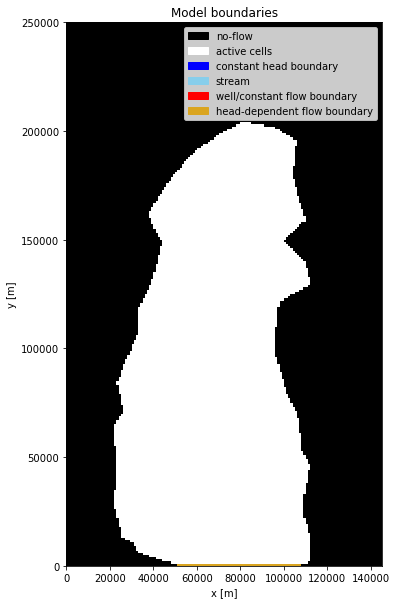

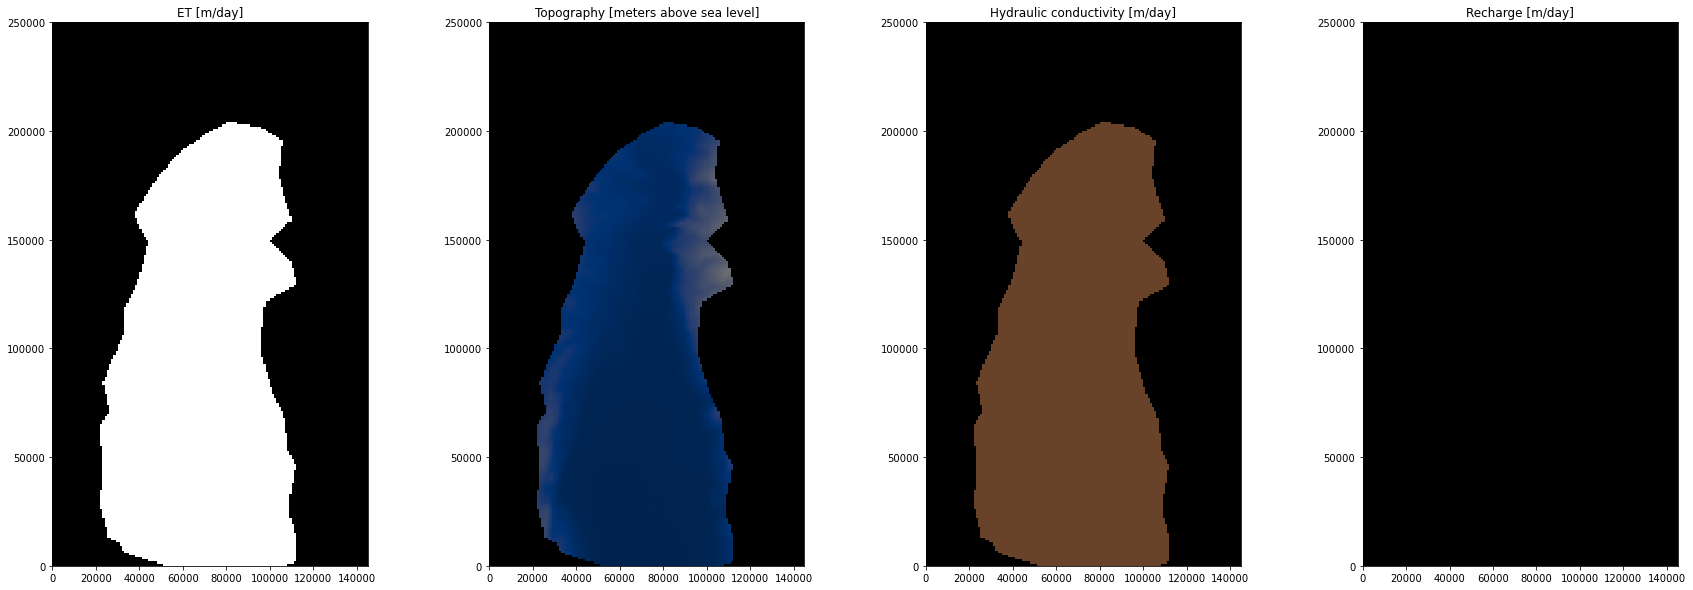

In [43]:
#Plot model boundaries and hydraulic properties:
f,ax = plt.subplots(1,1,figsize=(10,10))
ax.set_aspect('equal')
ax.set_title('Model boundaries')      #set first subplot title
m = flopy.plot.PlotMapView(model=mf, ax=ax, layer=0)     #create model map object on first subplot axes
#grid = m.plot_grid(colors='gray')                           #plot model grid
try: w = m.plot_bc('WEL', color='red', plotAll=True)              #plot wells
except: pass
try: s = m.plot_bc('STR', color='skyblue')                        #plot stream
except: pass
try: g = m.plot_bc('GHB', color='goldenrod')
except: pass
bc = m.plot_ibound()                                        #plot boundary conditions
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.legend(handles=[matplotlib.patches.Patch(color='black',label='no-flow'),      #add legend manually
                      matplotlib.patches.Patch(color='white',label='active cells'),
                      matplotlib.patches.Patch(color='blue',label='constant head boundary'),
                      matplotlib.patches.Patch(color='skyblue', label='stream'),
                      matplotlib.patches.Patch(color='red', label='well/constant flow boundary'),
                      matplotlib.patches.Patch(color='goldenrod', label='head-dependent flow boundary')
                    ])

f,ax = plt.subplots(1,4,figsize=(30,10))                    #create new figure and axes with subplots
m = flopy.plot.PlotMapView(model=mf, ax=ax[0], layer=0)     #create model map object on second subplot axes
ax[0].set_aspect('equal')
ax[0].set_title('ET [m/day]')                               #set first subplot title
#k = m.plot_array(ET, cmap='Greens', vmin=0,vmax=1)                   #plot array of horizontal hydraulic conductivities (set range manually to control colors)
bc = m.plot_ibound()                                        #plot boundary conditions

ax[1].set_title('Topography [meters above sea level]')      #set first subplot title
ax[1].set_aspect('equal')
m = flopy.plot.PlotMapView(model=mf, ax=ax[1], layer=0)     #create model map object on first subplot axes
t = m.plot_array(ztop, cmap='cividis')   #plot topography array
bc = m.plot_ibound()                                        #plot boundary conditions

m = flopy.plot.PlotMapView(model=mf, ax=ax[2], layer=0)     #create model map object on second subplot axes
ax[2].set_aspect('equal')
ax[2].set_title('Hydraulic conductivity [m/day]')           #set first subplot title
k = m.plot_array(Kx, cmap='copper', vmin=-100, vmax=200)    #plot array of horizontal hydraulic conductivities (set range manually to control colors)
bc = m.plot_ibound()                                        #plot boundary conditions

m = flopy.plot.PlotMapView(model=mf, ax=ax[3], layer=0)     #create model map object on second subplot axes
ax[3].set_aspect('equal')
ax[3].set_title('Recharge [m/day]')                         #set first subplot title
k = m.plot_array(rech, cmap='bone', vmin=0, vmax=1)                         #plot array of horizontal hydraulic conductivities (set range manually to control colors)
bc = m.plot_ibound()                                        #plot boundary conditions

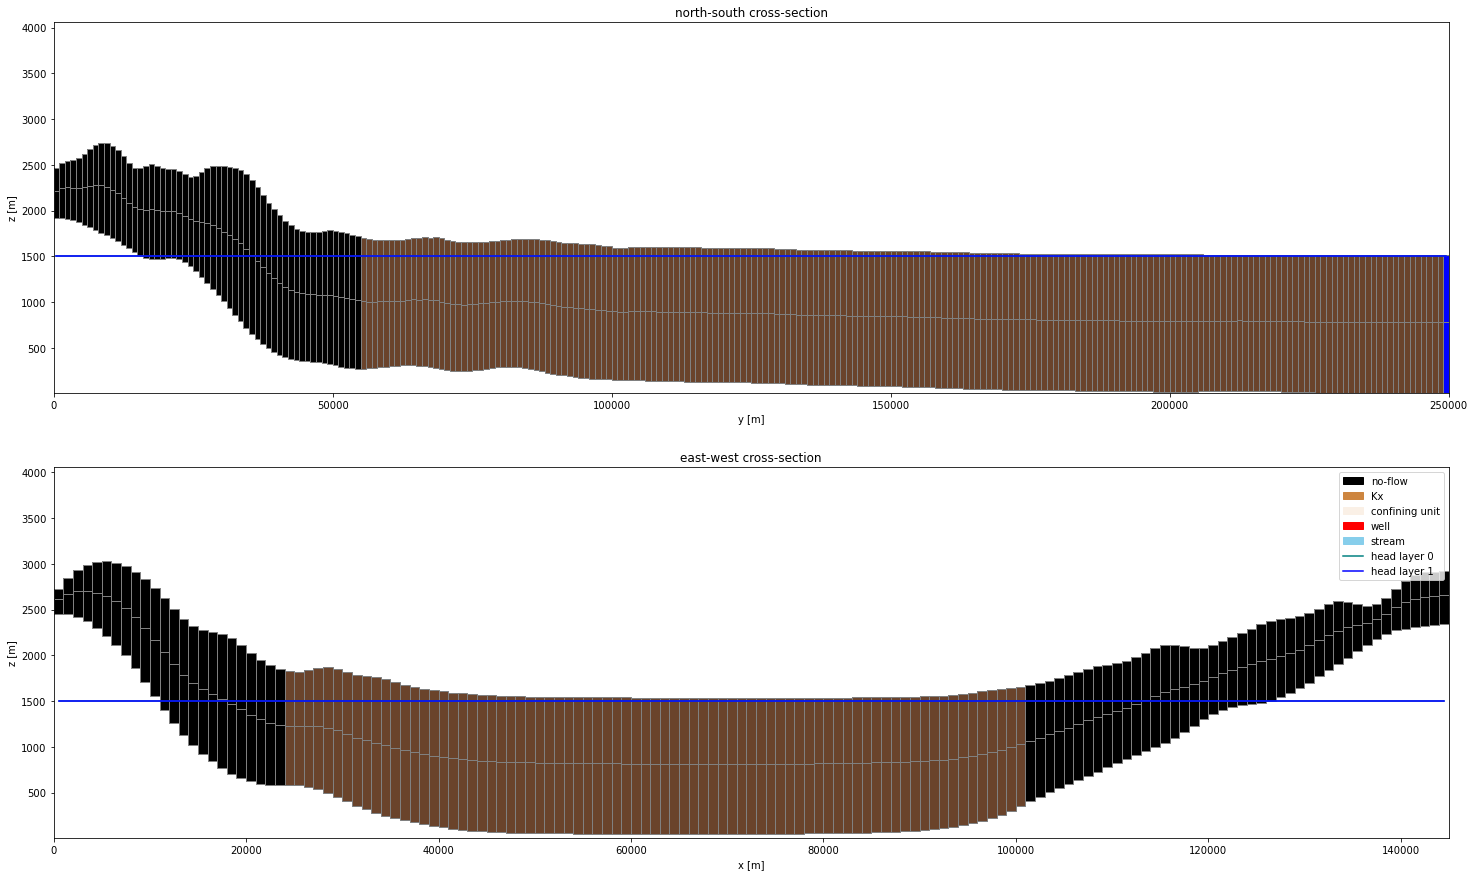

In [18]:
#Plot cross-section view of model:
row = 170     #row to plot on
col = 65      #column to plot on

#South-North:
f,ax = plt.subplots(2,1, figsize=(25,15))                                     #create empty figure and axes objects
xsec= flopy.plot.PlotCrossSection(model=mf, ax=ax[0], line={'column': col})  #plot cross-section along given column (change column # to see different locations)
k  = xsec.plot_array(Kx, cmap='copper', vmin=-100, vmax=200)                 #plot horizontal K as an array, with color range set manually to be consistent with other plots
ax[0].plot(np.arange(delr/2,Ly,delr), strt[0,:,col])                         #plots starting heads as a line
ax[0].plot(np.arange(delr/2,Ly,delr), strt[1,:,col], color='blue')           #plots starting heads as a line
bc = xsec.plot_ibound()                                                      #plot boundary conditions
#s  = xsec.plot_bc("STR", color='skyblue')                                    #plot stream
#w = xsec.plot_bc("WEL", color='red')                                         #plot wells (will only show wells at displayed column)
#g = m.plot_bc('GHB', color='goldenrod')                                      #plot head-dependent flow
g  = xsec.plot_grid()                                                        #plot model grid
ax[0].set_xlabel('y [m]')
ax[0].set_ylabel('z [m]')
ax[0].set_title('north-south cross-section')

#East-West:
xsec= flopy.plot.PlotCrossSection(model=mf, ax=ax[1], line={'Row': row})    #plot cross-ection along stream row
k  = xsec.plot_array(Kx, cmap='copper', vmin=-100, vmax=200)                #plot heads as an array, with color range set manually to be consistent with other plots
ax[1].plot(np.arange(delc/2,Lx,delc), strt[0,row,:])                        #plots starting heads as a line
ax[1].plot(np.arange(delc/2,Lx,delc), strt[1,row,:], color='blue')          #plots starting heads as a line
bc = xsec.plot_ibound()                                                     #plot boundary conditions
#s  = xsec.plot_bc("STR", color='skyblue')                                    #plot stream
#w = xsec.plot_bc("WEL", color='red')                                        #plot wells (will only show wells at displayed row)
#g = m.plot_bc('GHB', color='goldenrod')                                     #plot head-dependent flow
g  = xsec.plot_grid()                                                       #plot grid
ax[1].set_xlabel('x [m]')
ax[1].set_ylabel('z [m]')
ax[1].set_title('east-west cross-section')

plt.legend(handles=[matplotlib.patches.Patch(color='black',label='no-flow'),
                    matplotlib.patches.Patch(color='peru',label='Kx'),
                    matplotlib.patches.Patch(color='linen',label='confining unit'),
                    matplotlib.patches.Patch(color='red',label='well'),
                    matplotlib.patches.Patch(color='skyblue',label='stream'),
                    matplotlib.lines.Line2D([],[], color='teal',label='head layer 0'),
                    matplotlib.lines.Line2D([],[], color='blue',label='head layer 1')]) #add legend manually

## Run model ##
The code in this section will change very little

In [44]:
#Write MODFLOW input files:
mf.write_input()

#Run MODFLOW:
success, buff = mf.run_model()   #you should see "normal termination of simulation" printed below

FloPy is using the following executable to run the model: .\mf2005.EXE

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: ocotillo.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2022/02/28 15:05:26

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2022/02/28 15:05:28
 Elapsed run time:  2.169 Seconds

 FAILED TO MEET SOLVER CONVERGENCE CRITERIA            1  TIME(S)


## Get & view outputs ##

In [45]:
##Get outputs from binary output files:
#This section usually does not change much

#Get MODFLOW outputs:
hds = bf.HeadFile(modelname+'.hds')    #reads the raw binary head output file 
times = hds.get_times()                #returns a list of timesteps
head = hds.get_data(totim=times[-1])   #returns an array of heads for the specified time (last timestep)
head_mx = ma.masked_where(head<zbot, head)  #make a masked head array where all no-flow cells (with heads below the model bottom) are hidden

#Get cell-by-cell outputs from the cell budget output file:
#string options are in the list file under output control (make sure to include spaces!)
cbb = bf.CellBudgetFile(modelname+'.cbc')   #reads the cell budget file    
kstpkper_list = cbb.get_kstpkper()          #returns a list of stress periods & timesteps
frf = cbb.get_data(text='FLOW RIGHT FACE', totim=times[-1])[0]      #returns an array of flow rates for right face of cells
fff = cbb.get_data(text='FLOW FRONT FACE', totim=times[-1])[0]      #returns an array of flow rates for front face of cells
try:
    stf = cbb.get_data(text='STREAM FLOW OUT ', totim=times[-1])[0]     #returns an array of flow rates in stream cells
    stl = cbb.get_data(text='  STREAM LEAKAGE', totim=times[-1])[0]     #returns an array of leakage rates in stream cells
except: pass

In [46]:
#Calculate some basic stats about hydraulic head distribution:

print('General hydraulic head info:')
hmin = np.min(head_mx)                  #get min, max, mean of entire model
hmax = np.max(head_mx)
hmean = np.mean(head_mx)
print('max head total:\t',hmax,'m \tmin head total:\t',hmin,'m \tmean head total:',hmean,'m')

hmin0 = np.min(head_mx[0,:,:])          #get min,max,mean of just top layer
hmax0 = np.max(head_mx[0,:,:])
hmean0 = np.mean(head_mx[0,:,:])
print('max head lay 0:\t',hmax0,'m \tmin head lay 0:\t',hmin0,'m \tmean head:',hmean0,'m')

hmin0 = np.min(head_mx[0,:,:])          #get min,max,mean of just top layer
hmax0 = np.max(head_mx[0,:,:])
hmean0 = np.mean(head_mx[0,:,:])
print('max head lay 0:\t',hmax0,'m \tmin head lay 0:\t',hmin0,'m \tmean head:',hmean0,'m')
sys.exit()

hmin1 = np.min(head_mx[1,:,:])          #get min,max,mean of bottom layer
hmax1 = np.max(head_mx[1,:,:])
hmean1 = np.mean(head_mx[1,:,:])
print('max head lay 1:\t',hmax,'m \tmin head lay 1:\t',hmin,'m \tmean head:',hmean1,'m\n')

#Get head at specific location:
print('Hydraulic head a specific location')
lay = 0;  row = 100;  col = 50                                               #choose which cell to look at
print('head at lay',lay,'row', row, 'col', col,':', head[lay,row,col], 'm')  #get & print heads in that cell

General hydraulic head info:
max head total:	 138978.34 m 	min head total:	 125170.77 m 	mean head total: 133804.96897460902 m
max head lay 0:	 138971.38 m 	min head lay 0:	 125170.77 m 	mean head: 133702.19446499925 m
max head lay 0:	 138971.38 m 	min head lay 0:	 125170.77 m 	mean head: 133702.19446499925 m


SystemExit: 

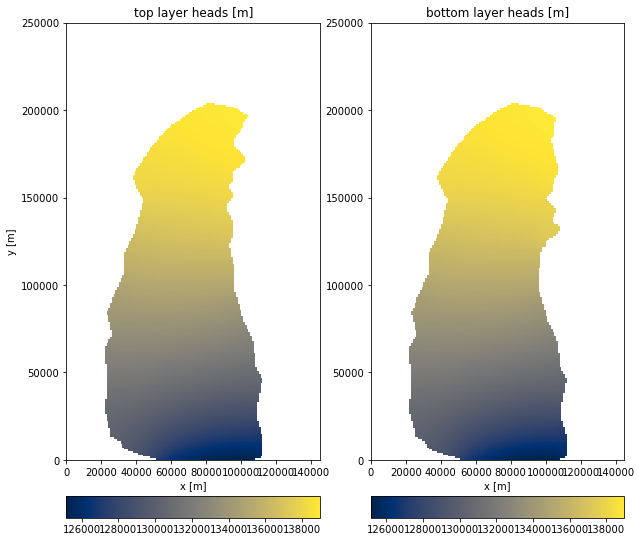

In [47]:
#Plot the hydraulic heads in each layer at the end of the model run
f,ax = plt.subplots(1,2, figsize=(10,10))         #create figure and axis objects

ax[0].set_title('top layer heads [m]')            #set figure title
ax[0].set_aspect('equal')                         #set aspect ratio equal to avoid stretching the map
maps = flopy.plot.PlotMapView(model=mf, ax=ax[0]) #create flopy map object
#h = maps.plot_array(head_mx[0,:,:], cmap='cividis', vmin=hmin,vmax=hmax)  #plot heads as color map
h = maps.plot_array(head_mx[:,:], cmap='cividis', vmin=hmin,vmax=hmax)  #plot heads as color map
levels = np.arange(hmin.round(-1), hmax.round(-1), 10)      #set contour range and interval (round to nearest 10)
#c = maps.contour_array(head[0,:,:], masked_values=[-999.99], levels=levels, colors='k') #plot head contours
#plt.clabel(c, rightside_up=False)   #add contour labels, not oriented up on the page but topographically up  
#w = maps.plot_bc("WEL", color='red',plotAll=True)                         #plot wells (in all layers)
#s = maps.plot_bc("STR", color='skyblue')                       #plot stream
ax[0].set_xlabel('x [m]')
ax[0].set_ylabel('y [m]')
divider = make_axes_locatable(ax[0])                      #make axes dividable (to add colorbar)
cax = divider.append_axes('bottom', size="5%", pad=0.5)   #add an axis at the bottom for the colorbar
plt.colorbar(h, cax=cax, orientation='horizontal')        #plot the colorbar

ax[1].set_title('bottom layer heads [m]')                 #set figure title
ax[1].set_aspect('equal')                                 #set aspect ratio
maps = flopy.plot.PlotMapView(model=mf, ax=ax[1])         #create flopy map object
h = maps.plot_array(head_mx[1,:,:], cmap='cividis', vmin=hmin,vmax=hmax)  #plot heads as grayscale map
levels = np.arange(hmin.round(-1),hmax.round(-1), 10)                      #set contour range and interval
#c = maps.contour_array(head[1,:,:], masked_values=[-999.99], levels=levels, colors='k') #plot head contours
#plt.clabel(c, rightside_up=False)   #add contour labels, not oriented for reading but for contour direction  
#w = maps.plot_bc("WEL", color='red', plotAll=True)                        #plot wells
ax[1].set_xlabel('x [m]')
divider = make_axes_locatable(ax[1])                      #make axes dividable (to add colorbar)
cax = divider.append_axes('bottom', size="5%", pad=0.5)   #add an axis at the bottom for the colorbar
plt.colorbar(h, cax=cax, orientation='horizontal')        #plot the colorbar

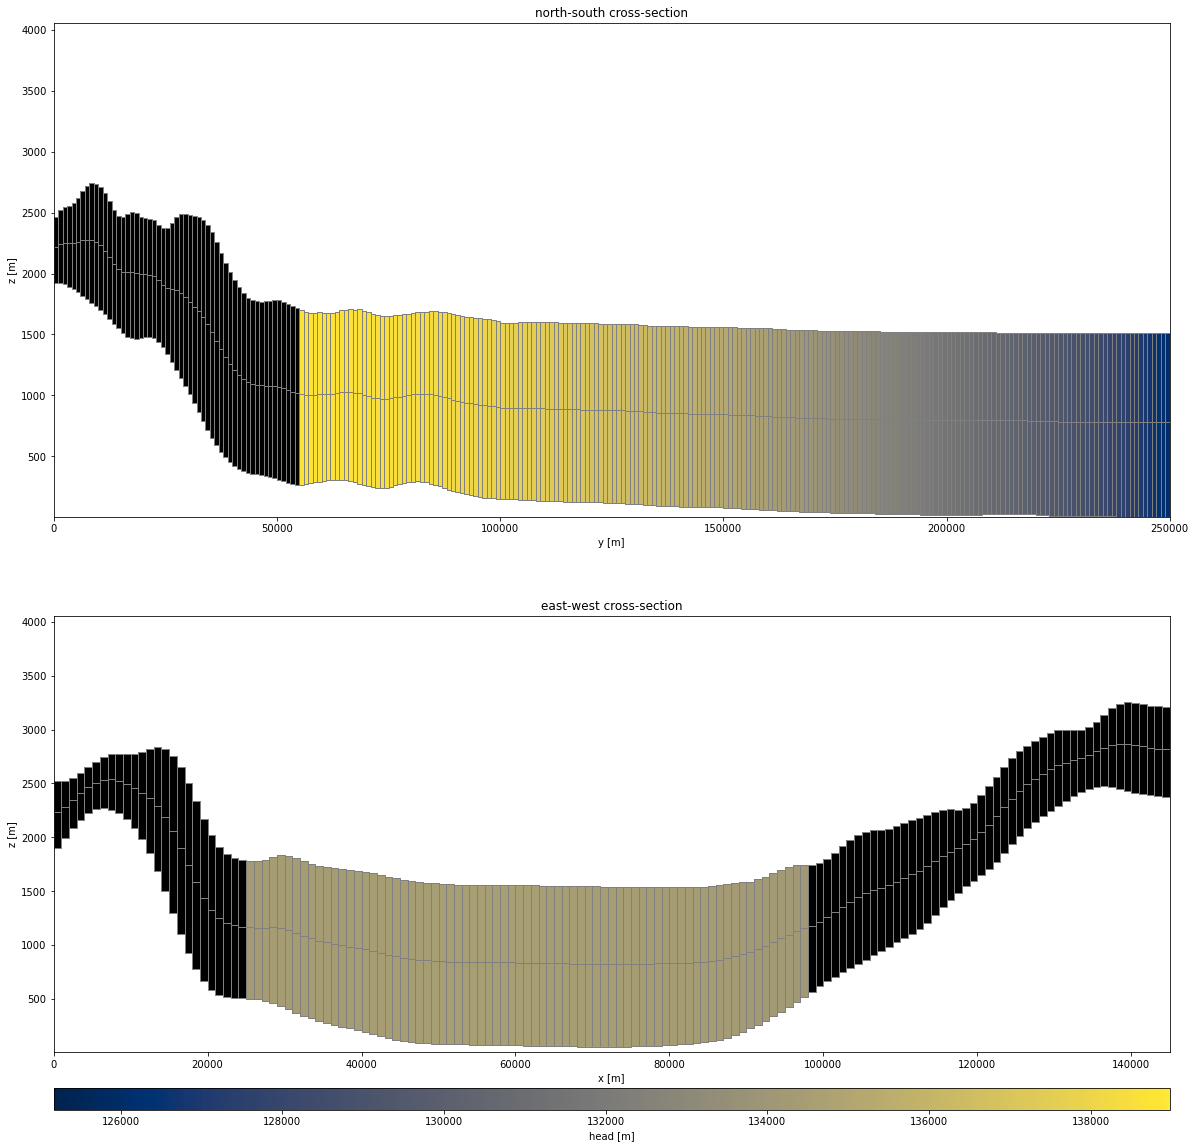

In [48]:
#Plot cross-section view of heads at center row and column:
row = 160   #row to plot cross-section along
col = 65   #column to plot cross-section along

f,ax = plt.subplots(2,1, figsize=(20,20))                                     #create empty figure and axes objects
xsec= flopy.plot.PlotCrossSection(model=mf, ax=ax[0], line={'column': col})  #plot cross-section along given column (change column # to see different locations)
h  = xsec.plot_array(head, masked_values=[-999.99], head=head, cmap='cividis', vmin=hmin,vmax=hmax)  #plot heads as an array, with color range set by min and max of full array
ax[0].plot(np.arange(delr/2,Ly,delr), head_mx[0,:,col], color='teal')        #plot head in top layer as a line
#ax[0].plot(np.arange(delr/2,Ly,delr), head_mx[1,:,col], color='blue')        #plot head in bottom layer as a line
bc = xsec.plot_ibound()                                                      #plot boundary conditions
#s = xsec.plot_bc("STR", color='skyblue')                                     #plot stream
#w = xsec.plot_bc("WEL", color='red')                                         #plot wells
g  = xsec.plot_grid()                                                        #plot model grid
ax[0].set_xlabel('y [m]')
ax[0].set_ylabel('z [m]')
ax[0].set_title('north-south cross-section')

xsec= flopy.plot.PlotCrossSection(model=mf, ax=ax[1], line={'row': row})      #plot cross-ection along given row
h  = xsec.plot_array(head, masked_values=[-999.99], head=head, cmap='cividis', vmin=hmin,vmax=hmax)   #plot heads as array with same color range as above
bc = xsec.plot_ibound()                                                      #plot boundary conditions
ax[1].plot(np.arange(delc/2,Lx,delc), head_mx[0,row,:], color='teal')        #plot head in top layer as a line
#ax[1].plot(np.arange(delc/2,Lx,delc), head_mx[1,row,:], color='blue')        #plot head in bottom layer as a line
#s = xsec.plot_bc("STR", color='skyblue')                                     #plot wells
#w = xsec.plot_bc("WEL", color='red')                                         #plot wells
g  = xsec.plot_grid()                                                        #plot grid
ax[1].set_xlabel('x [m]')
ax[1].set_ylabel('z [m]')
ax[1].set_title('east-west cross-section')

#Add colorbar:
divider = make_axes_locatable(ax[1])                     #make axes dividable (to add colorbar)
cax = divider.append_axes('bottom', size="5%", pad=0.5)  #add an axis at the bottom for the colorbar
c = plt.colorbar(h, cax=cax, orientation='horizontal')   #plot the colorbar
c.set_label('head [m]')                                  #label the colorbar

In [49]:
#Display water budget:

#Get water budget information:
lst = flopy.utils.MfListBudget(modelname+'.list')       #read the list file
budget = lst.get_data()                                 #get cumulative water budget for last timestep
labels = [str(budget[i][2])[2:] for i in np.arange(len(budget))] #get and trim labels for each budget item (one-line for loop)
vals = [budget[i][1] for i in np.arange(len(budget))]   #get values for each budget item

#Print water budget:
print('%25s'%'MASS BALANCE','\n')   #print right-justified header taking up 25 spaces, then go to new line
b=[print("%25s"%labels[i],'\t',"%10s"%vals[i]) for i in np.arange(len(budget))]  #iterate to print each item in buget

#Print timesteps:
print('\ntimesteps:',times)
print('stress periods:', kstpkper_list)

             MASS BALANCE 

              STORAGE_IN' 	        0.0
        CONSTANT_HEAD_IN' 	        0.0
      HEAD_DEP_BOUNDS_IN' 	        0.0
             RECHARGE_IN' 	  1417299.9
                TOTAL_IN' 	  1417299.9
             STORAGE_OUT' 	       -0.0
       CONSTANT_HEAD_OUT' 	       -0.0
     HEAD_DEP_BOUNDS_OUT' 	 -1417299.9
            RECHARGE_OUT' 	       -0.0
               TOTAL_OUT' 	 -1417299.9
                  IN-OUT' 	        0.0
     PERCENT_DISCREPANCY' 	        0.0

timesteps: [1.0]
stress periods: [(0, 0)]


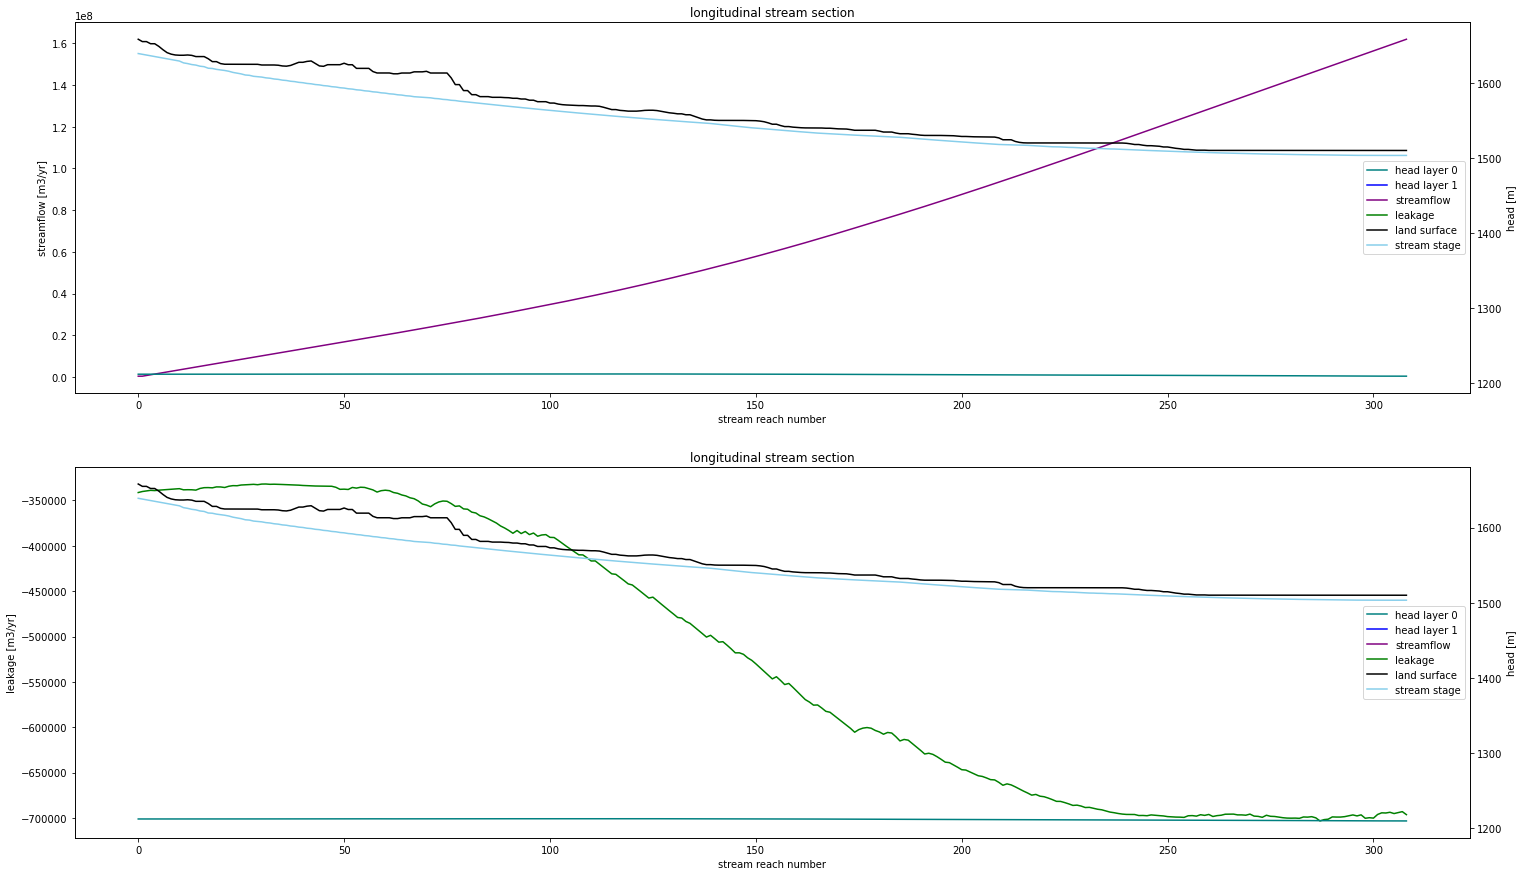

In [878]:
#Plot streamflow and leakage along stream:

#Extract streamflow & leakage data
strflows = np.zeros((nreach))       #create array of zeros the length of the stream
strleaks = np.zeros((nreach))       #create array of zeros the length of the stream
for i in np.arange(nreach):         #iterate over each reach
    strflows[i] = stf[i][1]         #get flow from stf array
    strleaks[i] = stl[i][1]         #get leakage from stl array

str_rows = str_info[:,1].astype(int) #get row indices and convert to integers so they can be used for indexing later
str_cols = str_info[:,2].astype(int) #repeat with columns

#Create figure & plot data:
fig,ax = plt.subplots(2,1,figsize=(25,15))  #create figure object with subplots and set overall figure size
ax2 = ax[0].twinx()                         #make secondary y axis
ax[0].set_xlabel('stream reach number')
ax[0].set_ylabel('streamflow [m3/yr]')
ax2.set_ylabel('head [m]')     #label second y axis
ax[0].set_title('longitudinal stream section')
f = ax[0].plot(np.arange(nreach), strflows, c='purple', label='streamflow')    #plot flows in each stream cell 
hl0 = ax2.plot(np.arange(nreach), head[0,str_rows,str_cols], c='teal' )        #plot aquifer heads in top layer
#hl1 = ax2.plot(np.arange(nreach), head[1,str_rows,str_cols], c='blue' )       #plot aquifer heads in bottom layer
zl = ax2.plot(np.arange(nreach), ztop[str_rows,str_cols], c='black')           #plot land surface elevation
sl = ax2.plot(np.arange(nreach), stage, c='skyblue')                           #plot stream stage
plt.legend(handles=[matplotlib.lines.Line2D([],[], color='teal', label='head layer 0'),
                    matplotlib.lines.Line2D([],[], color='blue', label='head layer 1'),
                    matplotlib.lines.Line2D([],[], color='purple', label='streamflow'),
                    matplotlib.lines.Line2D([],[], color='green', label='leakage'),
                    matplotlib.lines.Line2D([],[], color='black', label='land surface'),
                    matplotlib.lines.Line2D([],[], color='skyblue', label='stream stage')],
                    loc='right' ) #add legend manually

ax2 = ax[1].twinx()                      #add a second y axis
ax[1].set_xlabel('stream reach number')  #set axis labels
ax[1].set_ylabel('leakage [m3/yr]')
ax2.set_ylabel('head [m]')              
ax[1].set_title('longitudinal stream section')
l = ax[1].plot(np.arange(nreach), strleaks, c='green', label='leakage')         #plot flows in each stream cell on second y axis
hl0 = ax2.plot(np.arange(nreach), head[0,str_rows,str_cols], c='teal' )         #plot aquifer heads in top layer
#hl1 = ax2.plot(np.arange(nreach), head[1,str_rows,str_cols], c='blue' )        #plot aquifer heads in bottom layer
zl = ax2.plot(np.arange(nreach), ztop[str_rows,str_cols], c='black')            #plot land surface elevation
sl = ax2.plot(np.arange(nreach), stage, c='skyblue')                            #plot stream stage
plt.legend(handles=[matplotlib.lines.Line2D([],[], color='teal', label='head layer 0'),
                    matplotlib.lines.Line2D([],[], color='blue', label='head layer 1'),
                    matplotlib.lines.Line2D([],[], color='purple', label='streamflow'),
                    matplotlib.lines.Line2D([],[], color='green', label='leakage'),
                    matplotlib.lines.Line2D([],[], color='black', label='land surface'),
                    matplotlib.lines.Line2D([],[], color='skyblue', label='stream stage')],
                    loc='right') #add legend manually


In [594]:
np.savetxt('head0.csv',head[0,:,:],delimiter=',')